In [1]:
#%pip install segmentation-models-pytorch
import os
from glob import glob
from PIL import Image
import PIL
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
import segmentation_models_pytorch as smp
from tqdm import tqdm
import matplotlib.pyplot as plt

c:\Users\Jakob\Programming_projects\Python_projects\DS-exam\Datascience-exam\ml_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATCH_DIR = "patches"
MASK_DIR = "masks"
IMG_SIZE = 256
BATCH_SIZE = 8
EPOCHS = 20
LEARNING_RATE = 1e-4
SIZE_BUCKETS = {"small": 0, "medium": 1, "large": 2}

In [3]:
# Dataset definition
class PatchDataset(Dataset):
    def __init__(self, patch_dir, mask_dir, transform=None):
        self.samples = []
        self.transform = transform

        for patch_path in glob(os.path.join(patch_dir, "*.tif")):
            filename = os.path.basename(patch_path)
            parts = filename.split("_")
            print(f"Parsing patch filename: {filename} -> parts: {parts}")
            negpos = parts[0]
            bucket = parts[2]
            idx = parts[3].split(".")[0]
            mask_path = os.path.join(mask_dir, f"{negpos}_mask_{bucket}_{idx}.tif")
            print(f"Looking for mask: {mask_path}")

            if os.path.exists(mask_path):
                self.samples.append((patch_path, mask_path, bucket))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path, bucket = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)

        return img, mask, SIZE_BUCKETS[bucket], img_path


# Multi-head UNet definition
class MultiHeadUNet(nn.Module):
    def __init__(self, encoder_name="resnet50", n_heads=3, encoder_weights="imagenet"):
        super().__init__()
        # Use pretrained UNet backbone
        self.unet = smp.Unet(
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            in_channels=3,
            classes=1,
        )
        # Replace final segmentation head with identity
        #self.unet.segmentation_head = nn.Identity()

        # One head per bucket
        self.heads = nn.ModuleDict({
            str(i): nn.Conv2d(1, 1, kernel_size=1) for i in range(n_heads)
        })

    def forward(self, x, bucket_idx):
        x = self.unet(x)  # [batch, 1, H, W]

        if bucket_idx is None:
        # Run all samples through all heads and return a dict
            out_dict = {}
            for key, head in self.heads.items():
                out = head(x)  # [batch, 1, H, W]
                out_dict[key] = out
            return out_dict
        outs = []
        for feat, bucket in zip(x, bucket_idx):
            # feat: [1, H, W] -> [1, 1, H, W]
            feat = feat.unsqueeze(0)
            key = str(int(bucket.cpu().item()))
            out = self.heads[key](feat)  # [1, 1, H, W]
            outs.append(out)
        # Stack along batch dimension and remove extra batch dim: [batch, 1, H, W]
        return torch.cat(outs, dim=0)

In [5]:
print(os.path.join(PATCH_DIR, "*.tif"))
patch_files = glob(os.path.join(PATCH_DIR, "*.tif"))
mask_files = glob(os.path.join(MASK_DIR, "*.tif"))

print(f"Found {len(patch_files)} patch files in {PATCH_DIR}")
print(f"Found {len(mask_files)} mask files in {MASK_DIR}")


# Data loading and train/test split
transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor()
])
dataset = PatchDataset(PATCH_DIR, MASK_DIR, transform=transform)
print(f"Number of samples: {len(dataset)}")

# Show a few samples
for i in range(min(3, len(dataset))):
    img, mask, bucket, img_path = dataset[i]
    print(f"Sample {i}: img shape={img.shape}, mask shape={mask.shape}, bucket={bucket}")


patches\*.tif
Found 744 patch files in patches
Found 744 mask files in masks
Parsing patch filename: neg_patch_large_0.tif -> parts: ['neg', 'patch', 'large', '0.tif']
Looking for mask: masks\neg_mask_large_0.tif
Parsing patch filename: neg_patch_large_1.tif -> parts: ['neg', 'patch', 'large', '1.tif']
Looking for mask: masks\neg_mask_large_1.tif
Parsing patch filename: neg_patch_large_10.tif -> parts: ['neg', 'patch', 'large', '10.tif']
Looking for mask: masks\neg_mask_large_10.tif
Parsing patch filename: neg_patch_large_11.tif -> parts: ['neg', 'patch', 'large', '11.tif']
Looking for mask: masks\neg_mask_large_11.tif
Parsing patch filename: neg_patch_large_12.tif -> parts: ['neg', 'patch', 'large', '12.tif']
Looking for mask: masks\neg_mask_large_12.tif
Parsing patch filename: neg_patch_large_13.tif -> parts: ['neg', 'patch', 'large', '13.tif']
Looking for mask: masks\neg_mask_large_13.tif
Parsing patch filename: neg_patch_large_14.tif -> parts: ['neg', 'patch', 'large', '14.tif']
Lo

In [11]:

# Check if PATCH_DIR and MASK_DIR contain any .tif files


if len(dataset) == 0:
    print("Warning: Dataset is empty. Please check that PATCH_DIR and MASK_DIR contain valid data.")

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Ensure at least one sample in each split if possible
if train_size == 0 and len(dataset) > 0:
    train_size = 1
    test_size = len(dataset) - 1
elif test_size == 0 and len(dataset) > 1:
    test_size = 1
    train_size = len(dataset) - 1

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) if train_size > 0 else None
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE) if test_size > 0 else None


# Initialize model, optimizer, and loss function
model = MultiHeadUNet(n_heads=3).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()


In [12]:
# Training loop
def train():
    model.train()
    for epoch in range(EPOCHS):
        epoch_loss = 0
        for imgs, masks, buckets, img_path in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            buckets = buckets.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(imgs, buckets)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch+1} - Train Loss: {epoch_loss/len(train_loader):.4f}")


In [13]:
# Evaluation loop
def evaluate():
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for imgs, masks, buckets, img_path in tqdm(test_loader, desc="Evaluating"):
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            buckets = buckets.to(DEVICE)
            outputs = model(imgs, buckets)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

    print(f"Test Loss: {total_loss/len(test_loader):.4f}")


In [14]:
# Run training and evaluation
if __name__ == "__main__":
    train()
    evaluate()

Epoch 1/20: 100%|██████████| 75/75 [00:08<00:00,  8.41it/s]


Epoch 1 - Train Loss: 0.3896


Epoch 2/20: 100%|██████████| 75/75 [00:07<00:00,  9.86it/s]


Epoch 2 - Train Loss: 0.3063


Epoch 3/20: 100%|██████████| 75/75 [00:07<00:00,  9.92it/s]


Epoch 3 - Train Loss: 0.2668


Epoch 4/20: 100%|██████████| 75/75 [00:07<00:00,  9.98it/s]


Epoch 4 - Train Loss: 0.2472


Epoch 5/20: 100%|██████████| 75/75 [00:07<00:00, 10.00it/s]


Epoch 5 - Train Loss: 0.2283


Epoch 6/20: 100%|██████████| 75/75 [00:07<00:00, 10.03it/s]


Epoch 6 - Train Loss: 0.2153


Epoch 7/20: 100%|██████████| 75/75 [00:07<00:00, 10.02it/s]


Epoch 7 - Train Loss: 0.2093


Epoch 8/20: 100%|██████████| 75/75 [00:07<00:00, 10.01it/s]


Epoch 8 - Train Loss: 0.1962


Epoch 9/20: 100%|██████████| 75/75 [00:07<00:00,  9.99it/s]


Epoch 9 - Train Loss: 0.1783


Epoch 10/20: 100%|██████████| 75/75 [00:07<00:00, 10.00it/s]


Epoch 10 - Train Loss: 0.1630


Epoch 11/20: 100%|██████████| 75/75 [00:07<00:00,  9.99it/s]


Epoch 11 - Train Loss: 0.1625


Epoch 12/20: 100%|██████████| 75/75 [00:07<00:00,  9.99it/s]


Epoch 12 - Train Loss: 0.1542


Epoch 13/20: 100%|██████████| 75/75 [00:07<00:00,  9.99it/s]


Epoch 13 - Train Loss: 0.1565


Epoch 14/20: 100%|██████████| 75/75 [00:07<00:00,  9.91it/s]


Epoch 14 - Train Loss: 0.1611


Epoch 15/20: 100%|██████████| 75/75 [00:07<00:00, 10.01it/s]


Epoch 15 - Train Loss: 0.1364


Epoch 16/20: 100%|██████████| 75/75 [00:07<00:00, 10.01it/s]


Epoch 16 - Train Loss: 0.1327


Epoch 17/20: 100%|██████████| 75/75 [00:07<00:00, 10.00it/s]


Epoch 17 - Train Loss: 0.1317


Epoch 18/20: 100%|██████████| 75/75 [00:07<00:00, 10.00it/s]


Epoch 18 - Train Loss: 0.1221


Epoch 19/20: 100%|██████████| 75/75 [00:07<00:00, 10.01it/s]


Epoch 19 - Train Loss: 0.1233


Epoch 20/20: 100%|██████████| 75/75 [00:07<00:00, 10.00it/s]


Epoch 20 - Train Loss: 0.1151


Evaluating: 100%|██████████| 19/19 [00:00<00:00, 23.53it/s]

Test Loss: 0.2675


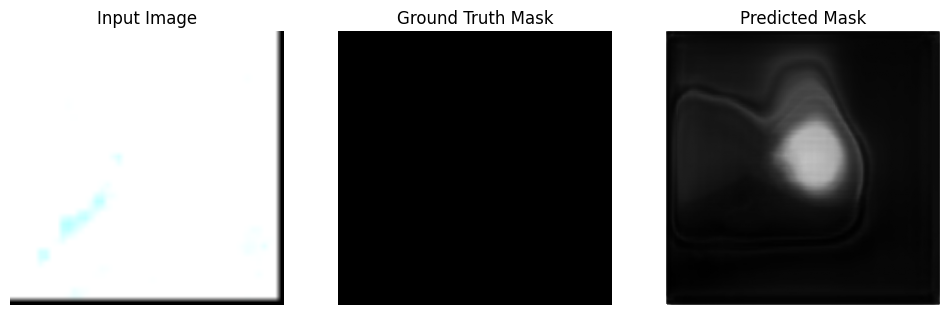

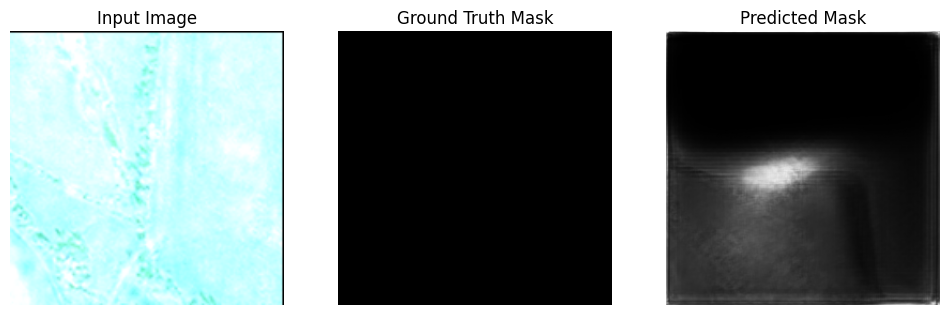

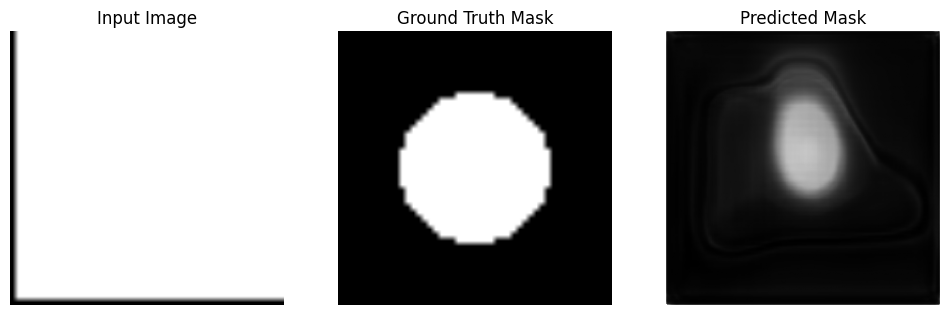

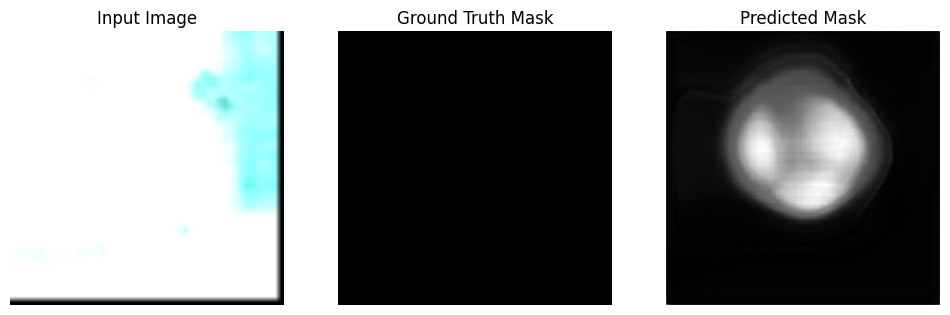

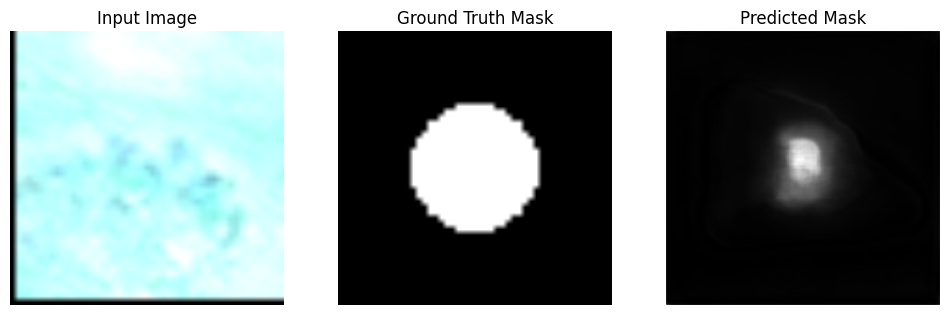

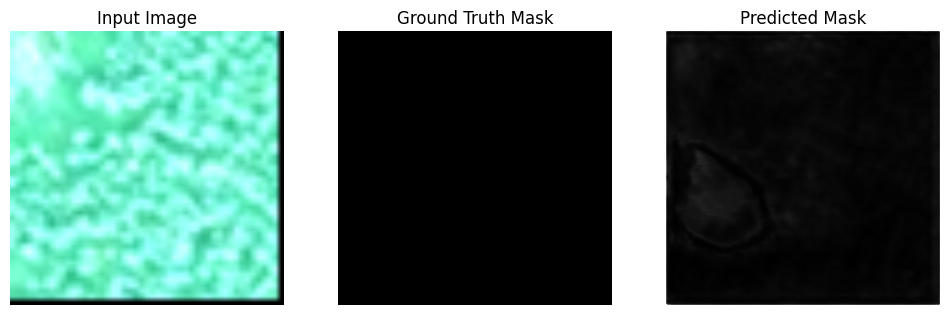

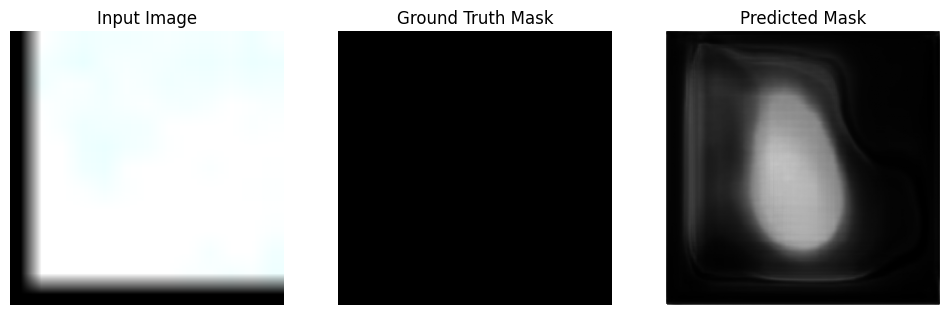

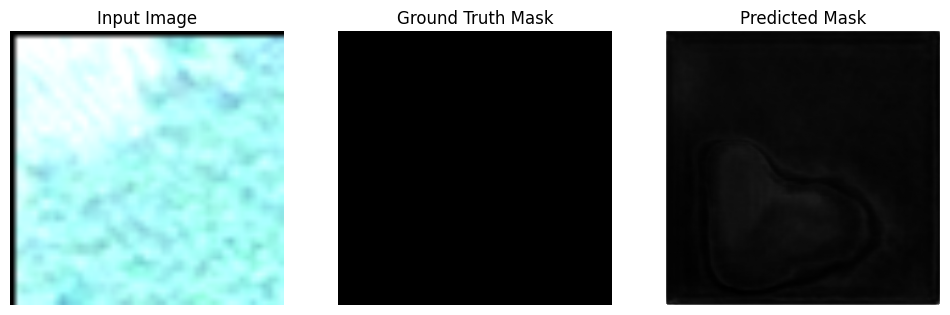

In [17]:


def show_predictions(model, loader, device, num_samples=3):
    model.eval()
    with torch.no_grad():
        for imgs, masks, buckets, img_paths in loader: 
            imgs = imgs.to(device)
            buckets = buckets.to(device)
            preds = torch.sigmoid(model(imgs, buckets)).cpu()
            imgs = imgs.cpu()
            masks = masks.cpu()
            for i in range(min(num_samples, imgs.size(0))):
                fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                axs[0].imshow(imgs[i].permute(1, 2, 0))
                axs[0].set_title("Input Image")
                axs[1].imshow(masks[i][0], cmap='gray')
                axs[1].set_title("Ground Truth Mask")
                axs[2].imshow(preds[i][0], cmap='gray')
                axs[2].set_title("Predicted Mask")
                for ax in axs:
                    ax.axis('off')
                plt.show()
            break  # Only show one batch

# Call after training:
show_predictions(model, test_loader, DEVICE, num_samples=50)

In [16]:
os.makedirs("predictions", exist_ok=True)
pred_path = "predictions"

model.eval()
with torch.no_grad():
    for batch_idx, batch in enumerate(test_loader):
        if len(batch) == 4:
            images, masks, bucket_idxs, img_paths = batch
        else:
            images, masks, bucket_idxs = batch
            img_paths = [f"img_{batch_idx}_{i}" for i in range(images.size(0))]  # fallback

        images = images.to(DEVICE)
        outputs = model(images, bucket_idx=None)
        for head_name, preds in outputs.items():
            preds = torch.sigmoid(preds)
            preds = (preds > 0.5).float()
            for i in range(preds.size(0)):
                pred_img = preds[i, 0].cpu().numpy() * 255
                pred_img = pred_img.astype(np.uint8)
                # Use the original filename (or index) in the save path
                base = os.path.splitext(os.path.basename(img_paths[i]))[0]
                save_path = os.path.join(pred_path, f"{head_name}_{base}.png")
                PIL.Image.fromarray(pred_img).save(save_path)

In [20]:
ALT_PATCH_DIR = "more_patches"
ALT_MASK_DIR = "more_masks"


print(os.path.join(ALT_PATCH_DIR, "*.tif"))
patch_files = glob(os.path.join(ALT_PATCH_DIR, "*.tif"))
mask_files = glob(os.path.join(ALT_MASK_DIR, "*.tif"))

print(f"Found {len(patch_files)} patch files in {ALT_PATCH_DIR}")
print(f"Found {len(mask_files)} mask files in {ALT_MASK_DIR}")


# Data loading and train/test split
transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor()
])
alt_dataset = PatchDataset(ALT_PATCH_DIR, ALT_MASK_DIR, transform=transform)
print(f"Number of samples: {len(alt_dataset)}")

# Show a few samples
for i in range(min(3, len(alt_dataset))):
    img, mask, bucket, img_path = alt_dataset[i]
    print(f"Sample {i}: img shape={img.shape}, mask shape={mask.shape}, bucket={bucket}")

alt_loader = DataLoader(alt_dataset, batch_size=BATCH_SIZE)

more_patches\*.tif
Found 2313 patch files in more_patches
Found 2313 mask files in more_masks
Parsing patch filename: neg_patch_large_0.tif -> parts: ['neg', 'patch', 'large', '0.tif']
Looking for mask: more_masks\neg_mask_large_0.tif
Parsing patch filename: neg_patch_large_1.tif -> parts: ['neg', 'patch', 'large', '1.tif']
Looking for mask: more_masks\neg_mask_large_1.tif
Parsing patch filename: neg_patch_large_10.tif -> parts: ['neg', 'patch', 'large', '10.tif']
Looking for mask: more_masks\neg_mask_large_10.tif
Parsing patch filename: neg_patch_large_11.tif -> parts: ['neg', 'patch', 'large', '11.tif']
Looking for mask: more_masks\neg_mask_large_11.tif
Parsing patch filename: neg_patch_large_12.tif -> parts: ['neg', 'patch', 'large', '12.tif']
Looking for mask: more_masks\neg_mask_large_12.tif
Parsing patch filename: neg_patch_large_13.tif -> parts: ['neg', 'patch', 'large', '13.tif']
Looking for mask: more_masks\neg_mask_large_13.tif
Parsing patch filename: neg_patch_large_14.tif -

In [21]:



os.makedirs("more_predictions", exist_ok=True)
pred_path = "more_predictions"

model.eval()
with torch.no_grad():
    for batch_idx, batch in enumerate(alt_loader):
        if len(batch) == 4:
            images, masks, bucket_idxs, img_paths = batch
        else:
            images, masks, bucket_idxs = batch
            img_paths = [f"img_{batch_idx}_{i}" for i in range(images.size(0))]  # fallback

        images = images.to(DEVICE)
        outputs = model(images, bucket_idx=None)
        for head_name, preds in outputs.items():
            preds = torch.sigmoid(preds)
            preds = (preds > 0.5).float()
            for i in range(preds.size(0)):
                pred_img = preds[i, 0].cpu().numpy() * 255
                pred_img = pred_img.astype(np.uint8)
                # Use the original filename (or index) in the save path
                base = os.path.splitext(os.path.basename(img_paths[i]))[0]
                save_path = os.path.join(pred_path, f"{head_name}_{base}.png")
                PIL.Image.fromarray(pred_img).save(save_path)